In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

def remove_trailing_zeros(signal):
    return signal[:np.max(np.nonzero(signal)) + 1] if np.any(signal) else np.array([0])

def load_and_preprocess_data(normal_path, abnormal_path, test_size=0.3, random_state=42):
    normal_df = pd.read_csv(normal_path)
    abnormal_df = pd.read_csv(abnormal_path)

    X_normal, y_normal = normal_df.iloc[:, :-1].values, normal_df.iloc[:, -1].values
    X_abnormal, y_abnormal = abnormal_df.iloc[:, :-1].values, abnormal_df.iloc[:, -1].values

    X_normal = [remove_trailing_zeros(x) for x in X_normal]
    X_abnormal = [remove_trailing_zeros(x) for x in X_abnormal]

    max_length = max(max(len(x) for x in X_normal), max(len(x) for x in X_abnormal))

    X_normal = np.array([np.pad(x, (0, max_length - len(x)), constant_values=0) for x in X_normal])
    X_abnormal = np.array([np.pad(x, (0, max_length - len(x)), constant_values=0) for x in X_abnormal])

    X = np.vstack((X_normal, X_abnormal))
    y = np.hstack((y_normal, y_abnormal))

    indices = np.arange(len(y))
    np.random.shuffle(indices)
    X, y = X[indices], y[indices]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y, random_state=random_state)

    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = load_and_preprocess_data(
    '/content/drive/MyDrive/ECG_classification/archive/ptbdb_normal.csv',
    '/content/drive/MyDrive/ECG_classification/archive/ptbdb_abnormal.csv'
)

print("Training Data Shape:", X_train.shape)
print("Testing Data Shape:", X_test.shape)


Training Data Shape: (10185, 186)
Testing Data Shape: (4365, 186)


In [ ]:
from sklearn.utils.class_weight import compute_class_weight


class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(y_train),
                                     y=y_train)


class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
print("Class Weights:", class_weight_dict)


Class Weights: {0: 1.7988343341575415, 1: 0.6924802828392711}


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

class Attention(layers.Layer):
    def __init__(self):
        super(Attention, self).__init__()
        self.score_layer = layers.Dense(1, activation='tanh')
        self.softmax = layers.Softmax(axis=1)

    def call(self, inputs):
        """
        Apply attention mechanism to the input.
        - inputs: Tensor of shape (batch_size, time_steps, features)
        """
        scores = self.score_layer(inputs)
        attention_weights = self.softmax(scores)
        context_vector = tf.reduce_sum(attention_weights * inputs, axis=1)

        return context_vector



In [ ]:
from tensorflow.keras import Model, Input

def build_autoregressive_attention_model(input_shape):
    inputs = Input(shape=input_shape)

    x = layers.GRU(128, return_sequences=True)(inputs)

    attention_output = Attention()(x)

    x = layers.Dense(64, activation="relu")(attention_output)
    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = Model(inputs, outputs, name="Autoregressive_Attention_Model")
    return model


input_shape = (186, 1)
autoregressive_model = build_autoregressive_attention_model(input_shape)


autoregressive_model.summary()


Model: "Autoregressive_Attention_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 186, 1)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_6 (GRU)                          │ (None, 186, 128)            │          50,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ attention_4 (Attention)              │ (None, 128)                 │             129 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 58,754 (229.51 KB)

 Trainable params: 58,754 (229.51 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
autoregressive_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = autoregressive_model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    class_weight=class_weight_dict,
    validation_data=(X_test, y_test),
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]
)


Epoch 1/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.4825 - loss: 0.6844 - val_accuracy: 0.5407 - val_loss: 0.6329
Epoch 2/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.5436 - loss: 0.6342 - val_accuracy: 0.6179 - val_loss: 0.5745
Epoch 3/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.5751 - loss: 0.6024 - val_accuracy: 0.6309 - val_loss: 0.5700
Epoch 4/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.6072 - loss: 0.5918 - val_accuracy: 0.6314 - val_loss: 0.6230
Epoch 5/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.6509 - loss: 0.5556 - val_accuracy: 0.6882 - val_loss: 0.5282
Epoch 6/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.7050 - loss: 0.4901 - val_accuracy: 0.7773 - val_loss: 0.4210
Epoch 7/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.7577 - loss: 0.4438 - val_accuracy: 0.8071 - val_loss: 0.3987
Epoch 8/50
319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.7803 - loss: 0.4198 - val_accu

In [ ]:
test_loss, test_acc = autoregressive_model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_acc * 100:.2f}%, Test Loss: {test_loss:.2f}')


y_pred_prob = autoregressive_model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

autoregressive_model.save("/content/drive/MyDrive/ECG_classification/ptbdb_autoregressive_ecg_model.h5")


137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9873 - loss: 0.0408
Test Accuracy: 98.58%, Test Loss: 0.04
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


              precision    recall  f1-score   support

         0.0       0.98      0.97      0.97      1214
         1.0       0.99      0.99      0.99      3151

    accuracy                           0.99      4365
   macro avg       0.98      0.98      0.98      4365
weighted avg       0.99      0.99      0.99      4365



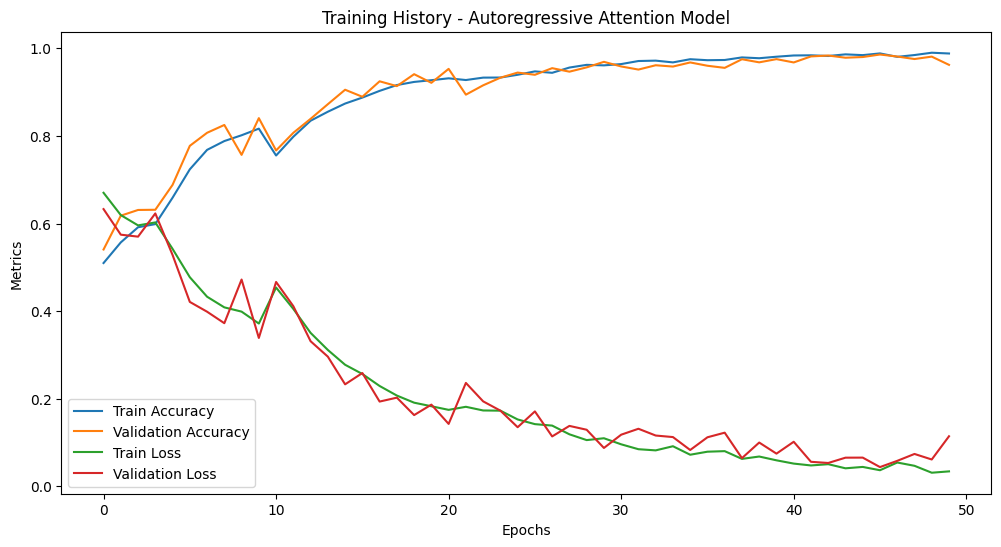

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Training History - Autoregressive Attention Model")
plt.xlabel("Epochs")
plt.ylabel("Metrics")
plt.show()
